In [22]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from source.featlearn.simclr import SimClrFL
from sklearn import svm
sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
from ts2vec import TS2Vec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
datasetName = 'PAMAP2' # PAMAP2 or HAR-UML20
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 20
N_EPOCHS = 2000
RESULTS_PATH = 'results'
TS2VEC = True

MODE = 2 # 0 -> UMAP  -  1 -> TS2Vec - 2 -> SimCLR 
NET_EPOCHS = 7

In [24]:


if datasetName == 'PAMAP2':
    signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3',]
    dataset = DatasetPAMAP2(mode = 'leave-one-subject')
    
elif datasetName ==  'HAR-UML20':
    signals = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z']
    dataset = DatasetHARUML20(mode = 'leave-one-subject')

elif datasetName == 'OpenDataset':
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'heart_rate ']
    # signals = ['heart_rate']
    signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    dataset = DatasetOpenDataset(mode = 'leave-one-subject')
    
    
CLASS_LABELS = dataset.activities

if MODE == 0:
    MODEL_NAME = 'umap'
elif MODE == 1:
    MODEL_NAME = 'ts2vec'
elif MODE == 2:
    MODEL_NAME = 'simclr'


saver = MetricsSaver(datasetName + '_HAR_{}'.format(MODEL_NAME), rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [25]:
predicted_classes = []
real_classes = []
while dataset.loadData():
    if datasetName == 'PAMAP2':
        le = LabelEncoder()
        dataset.y_train = le.fit_transform(dataset.y_train)
        dataset.y_test = le.transform(dataset.y_test)

    dataset.filterSignals(signals)
    
    # Preparing data
    if BALANCE:
        dataset.X_train, dataset.Int_train = minoritySampling(dataset.X_train, dataset.Int_train)
    
    
    # Preparing data
    ts_train = TSerie(dataset.X_train[:, :, :6], dataset.y_train)
    ts_test = TSerie(dataset.X_test[:, :, :6], dataset.y_test)
    # ts_train.center()
    # ts_test.center()
    
    if MODE == 0:
        ts_train.folding_features_v2()
        ts_test.folding_features_v2()
        ts_train.znorm()
        ts_test.znorm()
    
        # Getting features
        model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
        ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
        ts_test.features = model.transform(ts_test.features)
    
    if MODE == 1:
        model = TS2Vec(
            input_dims=ts_train.D,
            device=0,
            output_dims=64,
            batch_size=8,
        )
        model.fit(ts_train.X, verbose=True,n_epochs = NET_EPOCHS)
        ts_train.features = model.encode(ts_train.X, encoding_window='full_series')
        ts_test.features = model.encode(ts_test.X, encoding_window='full_series')
    elif MODE == 2:
        model = SimClrFL(
            ts_train.D, 
            ts_train.T,
            encoding_size = 16, 
            feature_size=128, 
            filters = [16, 16, 16],
            kernels = [3, 3, 3],
        )
        model.fit(ts_train.X.transpose([0, 2, 1]), 
                    epochs=20, 
                    batch_size=32,X_val = ts_test.X.transpose([0, 2, 1]),
        )
        ts_test.features = model.encode(ts_test.X.transpose([0, 2, 1]))
        ts_train.features = model.encode(ts_train.X.transpose([0, 2, 1]))


        
    
    
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    # clf = svm.SVC()
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)
    
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)
    break
    
predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

Epoch[1] Train loss    avg: 2.2607935371606245
Epoch[1] Val loss    avg: 2.1110468235882847
Epoch[10] Train loss    avg: 1.3556123712788457
Epoch[10] Val loss    avg: 1.5673832315387148
Epoch[20] Train loss    avg: 1.255769069298454
Epoch[20] Val loss    avg: 1.416955297643488


/home/texs/anaconda3/envs/cuml-torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
if datasetName == 'PAMAP2':
    classes = np.unique(real_classes)
    CLASS_LABELS = [dataset.activities_map[classL] for classL in le.inverse_transform(classes) ]

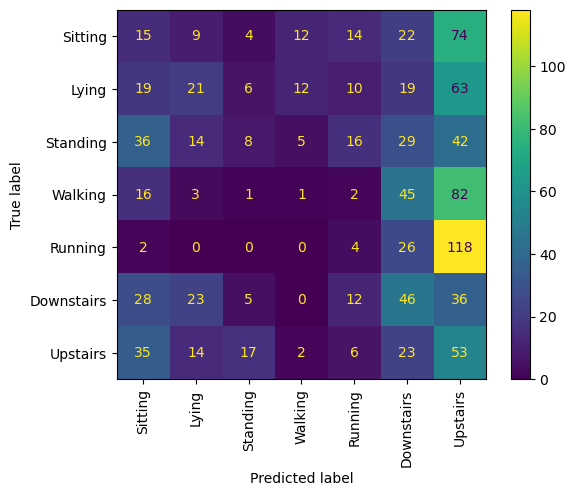

In [27]:

saveConfusionMatrix(real_classes, predicted_classes, datasetName + '_HAR_{}'.format(MODEL_NAME), labels=CLASS_LABELS, xrotation=90)

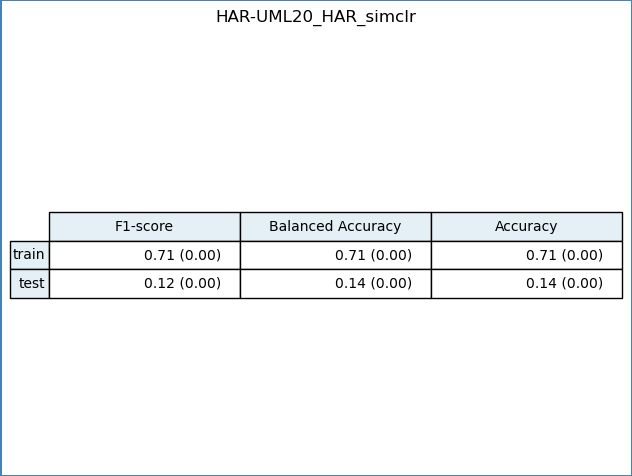

In [28]:
saver.toImage()